<a href="https://colab.research.google.com/github/LuluW8071/Text-Sentiment-Analysis/blob/main/Text-Sentiment-Analysis-using-BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text-Sentiment-Analysis-using-BERT

In [1]:
# Install new version of transformers, if you running this notebook for 1st time on the gpu
!pip uninstall transformers -y
!pip install transformers[torch]

Found existing installation: transformers 4.38.2
Uninstalling transformers-4.38.2:
  Successfully uninstalled transformers-4.38.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 27.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached

## 1. Download and Load the dataset

The dataset that the following script will download is a combination of the Yelp Polarity Dataset and the IMDb Movie Dataset. The Yelp Polarity Dataset has been preprocessed by selecting specific columns to create a dataset suitable for sentiment analysis. This preprocessed dataset has been merged with the IMDb Movie Dataset.

In [2]:
import gdown
import zipfile
import os

file_url = 'https://drive.google.com/uc?id=1Jp3D5gdxGrwa5dHbr4p-pECrD8wi7vik'
file_name = 'sentiment_dataset.zip'

# Download the file from Google Drive
gdown.download(file_url, file_name, quiet=False)
extract_dir = './dataset'

# Extract the zip file
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Remove the zip file after extraction
os.remove(file_name)
print("Files extracted successfully to:", extract_dir)

Downloading...
From (original): https://drive.google.com/uc?id=1Jp3D5gdxGrwa5dHbr4p-pECrD8wi7vik
From (redirected): https://drive.google.com/uc?id=1Jp3D5gdxGrwa5dHbr4p-pECrD8wi7vik&confirm=t&uuid=865f4c3b-27d0-4b5b-bcde-333336ca5473
To: /content/sentiment_dataset.zip
100%|██████████| 182M/182M [00:02<00:00, 74.5MB/s]


Files extracted successfully to: ./dataset


In [3]:
import pandas as pd
import numpy as np

>__Note:__</br>
**BERT** (Bidirectional Encoder Representations from Transformers) can indeed be trained on a relatively small dataset to yield improved results for certain tasks, especially when fine-tuning a pre-trained model, due to its powerful architecture. It is already pre-trained on larger datasets, possesses powerful contextual understanding, and benefits from effective regularization techniques such as dropout and attention mechanisms, which help prevent overfitting.

>So, we can just take just `20000` datasets and train the **BERT** Model on it for our purpose.

In [20]:
import random

# Reduce to 10000 samples if you want your model to train faster (while loss may increase)
samples = 20000

# Read dataset and take random 20000 samples
df = pd.read_csv("dataset/sentiment_combined.csv")
df = df.sample(n=samples, random_state=random.randint(0, 100))

# Reset the index
df.reset_index(drop=True, inplace=True)
df.head(), df.shape

(                                              review sentiment
 0  This was my first visit here after recently mo...  positive
 1  Jalape\u00f1o poppers are out of this world. N...  positive
 2  Excited about my first dining experience today...  negative
 3  Yelpers commenting on the Charlotte Area Trans...  positive
 4  I live for their nachos!!! My husband and I al...  positive,
 (20000, 2))

In [21]:
df['review'][0]

'This was my first visit here after recently moving to the Phoenix area this summer.  After living in CA, I have become accustomed to the being able to pop in local breweries for a beer and a bite...particularly in the San Diego area (incredible selection there, Stone is my favorite).  I really am trying to get into my local beers.  I enjoyed the Hope Knot IPA, so my wife surprised me for a lunch date at Four Peaks!  \\n\\nThe place was a little less polished than I imaged it would be, sort of a sports bar feel.  The food seletion looked good, typcial bar fare combined with some very unique selections.  We only order some pretzels...and I ordered the taster set so that I could explore their full line of beers.  The beer was good overall, not the best I have had.  I still think the Hop Knot is one of their best, and their ales are strong as well.  \\n\\nThe best thing about this place was the incredible service.  Despite the super casual feel, the service was fantastic.  Our server cove

In [22]:
df['sentiment'].value_counts()

sentiment
positive    10014
negative     9986
Name: count, dtype: int64

## 2. Text Pre-Processing

- Cleaning up the text data by removing punctuation, extra spaces, and numbers.
- Transform sentences into individual words, remove common words (known as "stop words")

In [23]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter

# Precompile regular expressions for faster pre processing
non_word_chars_pattern = re.compile(r"[^\w\s]")
whitespace_pattern = re.compile(r"\s+")
digits_pattern = re.compile(r"\d")
username_pattern = re.compile(r"@([^\s]+)")
hashtags_pattern = re.compile(r"#\d+")
br_pattern = re.compile(r'<br\s*/?>\s*<br\s*/?>')

def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = non_word_chars_pattern.sub('', s)
    # Replace all runs of whitespaces with single space
    s = whitespace_pattern.sub(' ', s)
    # Replace digits with no space
    s = digits_pattern.sub('', s)
    # Replace usernames with no space
    s = username_pattern.sub('', s)
    # Replace hashtags with no space
    s = hashtags_pattern.sub('', s)
    # Replace <br /> pattern with empty string
    s = br_pattern.sub('', s)
    # Replace specific characters
    s = s.replace("https", "")
    s = s.replace("http", "")
    s = s.replace("rt", "")
    s = s.replace("-", "")
    # Replace br with empty string
    s = s.replace("br", "")
    # Replace newline character with empty string
    s = s.replace("\n", "")
    return s

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
from tqdm.notebook import tqdm_notebook

preprocessed_reviews = []

# Apply preprocessing
for review in tqdm_notebook(df['review'], desc='Preprocessing'):
    preprocessed_review = preprocess_string(review)
    preprocessed_reviews.append(preprocessed_review)

# Assign the preprocessed reviews back to  'review' column
df['review'] = preprocessed_reviews

Preprocessing:   0%|          | 0/20000 [00:00<?, ?it/s]

In [25]:
df['review'][0], df['sentiment'][0]

('This was my first visit here after recently moving to the Phoenix area this summer After living in CA I have become accustomed to the being able to pop in local eweries for a beer and a bitepaicularly in the San Diego area incredible selection there Stone is my favorite I really am trying to get into my local beers I enjoyed the Hope Knot IPA so my wife surprised me for a lunch date at Four Peaks nnThe place was a little less polished than I imaged it would be so of a spos bar feel The food seletion looked good typcial bar fare combined with some very unique selections We only order some pretzelsand I ordered the taster set so that I could explore their full line of beers The beer was good overall not the best I have had I still think the Hop Knot is one of their best and their ales are strong as well nnThe best thing about this place was the incredible service Despite the super casual feel the service was fantastic Our server covered every detail offered wonderful suggestions and ch

## 3. Mapping `sentiment` column to numeric values

In [26]:
# Map 'positive' to 1 & 'negative' to 0
df['sentiment'] = df['sentiment'].replace({'positive': 1, 'negative': 0})
df.head()

,review,sentiment
0,This was my first visit here after recently mo...,1
1,Jalapeufo poppers are out of this world Never ...,1
2,Excited about my first dining experience today...,0
3,Yelpers commenting on the Charlotte Area Trans...,1
4,I live for their nachos My husband and I alway...,1


## 4. Spliiting datasets into train and test

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['review'],
                                                    df['sentiment'],
                                                    test_size=0.2)

len(X_train), len(X_test)

(16000, 4000)

In [28]:
X_train, X_test, y_train, y_test = list(X_train), list(X_test), list(y_train), list(y_test)
X_train[:2], y_train[:2]

(['Struggling to find a healthy restaurant free of the most common food allergies I stumbled upon Nourish Although they make a great effo to provide diverse allergy friendly food they fail miserably with poion size and I literally just ate a  southwestern bowl that I could recreate for no more than one or two dollars Do yourself a favor and just make something at home It will be significantly cheaper and will probably taste better Id give one star if not for the fact that this is the only allergy friendly restaurant in my area Very disappointed',
  'So I should sta this off by saying malls arent my favorite places to shop Overly commercial and trendy theyre just not my cup of tea That being said this mall is nothing great However compared to other malls in Vegas this is probably in my top two I go to this mall the most often This seems to be more due to location and friends than store options though nI mostly stick to one wing of the mall By Macys with the stores I frequent being Fashi

## 5. Preparing data using custom dataloader

In [29]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

# Setting device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [30]:
class data(Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, index):
    item = {key: torch.tensor(val[index]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[index])
    return item

  def __len__(self):
    return len(self.labels)

## 6. Load PreTrained BERT Model

**BERT** (Bidirectional Encoder Representations from Transformers) is a pre-trained language representation model developed by researchers at Google.

<img src = "https://i0.wp.com/neptune.ai/wp-content/uploads/2022/10/Attention_diagram_transformer.png?ssl=1">

- BERT architecture consists of `multiple encoder transformer blocks` stacked together.
- Each transformer block includes` multi-head self-attention` and `feed-forward neural networks`.
- `Multi-head self-attention` allows BERT to weigh word importance based on context, capturing long-range dependencies effectively.
- The output from `attention mechanisms` undergoes non-linear transformations via `feed-forward neural networks`.
- `Layer normalization` and `residual connections` stabilize training and facilitate gradient flow within each transformer block.
- `Positional encodings` preserve word order in sequences, aiding BERT in understanding the sequential nature of data.

>BERT is pre-trained on a large text corpus using tasks like masked language modeling and next sentence prediction. Fine-tuning on specific tasks involves adjusting the final layers of the pre-trained BERT model.

### [Explanation Video on BERT](https://www.youtube.com/watch?v=6ahxPTLZxU8)

In [31]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

## 7. Tokenize and Create Encoded Dataset

In [32]:
# Tokenize with truncation and padding and create dataset from tokenized data
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

train_dataset = data(train_encoding, y_train)
test_dataset = data(test_encoding, y_test)

## 8. Fine-Tuning BERT

Fine-tuning BERT, a pre-trained language model, allows us to adapt it to specific NLP tasks such as text classification, named entity recognition, sentiment analysis, and question answering.


<img src = "assets/BERT-Fine-tuning-pipeline.png">

In [33]:
training_args = TrainingArguments(
  output_dir='./results',            # Directory where model checkpoints & results will be saved
  num_train_epochs=3,                # No of training epochs
  per_device_train_batch_size=32,    # Batch size for training per device
  per_device_eval_batch_size=32,     # Batch size for evaluation per device
  learning_rate=2e-05,               # Learning rate for optimizer
  warmup_steps=500,                  # No of warmup steps for the learning rate scheduler
  weight_decay=0.01,                 # Weight decay coefficient for regularization
  logging_dir='./logs',              # Directory for logging training information
  load_best_model_at_end=True,       # Whether to load the best model from checkpoints at the end of training
  logging_steps=200,                 # Log training metrics every `logging_steps` steps
  save_steps=400,                    # Save model checkpoints every `save_steps` steps
  evaluation_strategy="steps",       # Evaluate on the evaluation dataset every `logging_steps` steps
)


## 9. Train the Fine-Tuned BERT Model

In [34]:
model = DistilBertForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=test_dataset)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [35]:
from accelerate import Accelerator

# Initialize Accelerator and Trainer
Accelerator()
trainer.train()

Step,Training Loss,Validation Loss
200,0.530300,0.256161
400,0.239100,0.190886
600,0.190700,0.218154
800,0.159300,0.168036
1000,0.153800,0.155893
1200,0.083200,0.191765
1400,0.078300,0.190448


TrainOutput(global_step=1500, training_loss=0.19693608029683432, metrics={'train_runtime': 2675.0753, 'train_samples_per_second': 17.943, 'train_steps_per_second': 0.561, 'total_flos': 6358435135488000.0, 'train_loss': 0.19693608029683432, 'epoch': 3.0})

## 10. Sentiment Prediction using custom text


In [36]:
# Tokenize text, get output from model and predict
def predict_sentiment(model, tokenizer, text, device):
    tokenized = tokenizer(text, truncation=True, padding=True, return_tensors='pt').to(device)
    outputs = model(**tokenized)

    probs = F.softmax(outputs.logits, dim=-1)
    preds = torch.argmax(outputs.logits, dim=-1).item()
    probs_max = probs.max().detach().cpu().numpy()

    prediction = "Positive" if preds == 1 else "Negative"
    print(f'{text}\nSentiment: {prediction}\tProbability: {probs_max*100:.2f}%\n', end="-"*50 + "\n")
    # return prediction, probs_max

In [37]:
texts = [
    "The traffic was horrendous this morning; I was stuck in it for over an hour.",
    "I was extremely disappointed with the quality of the product; it didn't meet my expectations at all.",
    "The customer service at the restaurant was very good; the staff went above and beyond to make us feel welcome.",
    "My recent stay at Paradise Resort was absolutely fantastic! From the moment I arrived, I was greeted with warm smiles and excellent service. The room was spacious, beautifully decorated, and spotlessly clean. I loved the breathtaking view from my balcony overlooking the pool and tropical gardens. The dining options were exceptional, and the resort's facilities were top-notch, offering everything from a fitness center to guided nature walks. Overall, Paradise Resort exceeded all my expectations, and I can't wait to return for another memorable stay!",
    "The movie started off promising, but it quickly went downhill. The plot was confusing, the acting was mediocre, and the ending was unsatisfying.",
    "I had a terrible experience at the restaurant last night. The food was cold, the service was slow, and the staff was rude.",
    "Despite the initial skepticism, I was pleasantly surprised by the performance of the new smartphone. Its sleek design, impressive camera quality, and fast processing speed exceeded my expectations.",
    "The concert was absolutely amazing! The energy of the performers, the enthusiasm of the crowd, and the quality of the music made it an unforgettable experience.",
    "I had high hopes for the book, but it turned out to be a disappointment. The characters were one-dimensional, the plot was predictable, and the writing style was uninspired.",
    "The presentation was well-prepared and delivered with confidence. The speaker engaged the audience effectively and provided valuable insights on the topic.",
    "The service at the hotel was impeccable. The staff was attentive, courteous, and always willing to assist with any request.",
    "The weather during our vacation was dreadful; it rained every day, and we were stuck indoors for most of the trip.",
    "The hiking trail offered breathtaking views of the mountains and lush forests. It was a challenging but rewarding experience.",
    "The customer support team was unhelpful and incompetent. They were unable to resolve my issue and seemed indifferent to my concerns.",
    "The play was a delightful blend of humor, drama, and suspense. The talented cast delivered stellar performances, and the storyline kept me engaged from start to finish.",
    "The new restaurant in town has quickly become my favorite dining spot. The food is delicious, the atmosphere is cozy, and the service is outstanding.",
]

for text in texts:
  predict_sentiment(model, tokenizer, text, device)

The traffic was horrendous this morning; I was stuck in it for over an hour.
Sentiment: Negative	Probability: 95.46%
--------------------------------------------------
I was extremely disappointed with the quality of the product; it didn't meet my expectations at all.
Sentiment: Negative	Probability: 97.87%
--------------------------------------------------
The customer service at the restaurant was very good; the staff went above and beyond to make us feel welcome.
Sentiment: Positive	Probability: 99.05%
--------------------------------------------------
My recent stay at Paradise Resort was absolutely fantastic! From the moment I arrived, I was greeted with warm smiles and excellent service. The room was spacious, beautifully decorated, and spotlessly clean. I loved the breathtaking view from my balcony overlooking the pool and tropical gardens. The dining options were exceptional, and the resort's facilities were top-notch, offering everything from a fitness center to guided nature 

In [38]:
# An example of complex review that contains both positive and negative sentiment
texts = ["Despite facing numerous challenges and setbacks, the team worked tirelessly and managed to exceed all expectations, achieving remarkable success. However, despite their best efforts, the project encountered multiple setbacks, ultimately leading to its failure and significant financial losses.",
         "The hotel room was clean and comfortable, and the amenities were well-maintained. However, the noise from the nearby construction site was disruptive due to which i could not focus when working.",
         "The movie had an intriguing plot and captivating visuals, but the sound quality was poor, making it difficult to fully enjoy the experience."]
for text in texts:
  predict_sentiment(model, tokenizer, text, device)

Despite facing numerous challenges and setbacks, the team worked tirelessly and managed to exceed all expectations, achieving remarkable success. However, despite their best efforts, the project encountered multiple setbacks, ultimately leading to its failure and significant financial losses.
Sentiment: Negative	Probability: 56.66%
--------------------------------------------------
The hotel room was clean and comfortable, and the amenities were well-maintained. However, the noise from the nearby construction site was disruptive due to which i could not focus when working. It was annoying as hell.
Sentiment: Negative	Probability: 75.92%
--------------------------------------------------
The movie had an intriguing plot and captivating visuals, but the sound quality was poor, making it difficult to fully enjoy the experience.
Sentiment: Negative	Probability: 79.98%
--------------------------------------------------


In [39]:
# Breaking down above example into parts
texts = ["Despite facing numerous challenges and setbacks, the team worked tirelessly and managed to exceed all expectations, achieving remarkable success.",
         "However, despite their best efforts, the project encountered multiple setbacks, ultimately leading to its failure and significant financial losses.",
         "The hotel room was clean and comfortable, and the amenities were well-maintained.",
         "However, the noise from the nearby construction site was disruptive due to which i could not focus when working."]

for text in texts:
  predict_sentiment(model, tokenizer, text, device)

Despite facing numerous challenges and setbacks, the team worked tirelessly and managed to exceed all expectations, achieving remarkable success.
Sentiment: Positive	Probability: 98.68%
--------------------------------------------------
However, despite their best efforts, the project encountered multiple setbacks, ultimately leading to its failure and significant financial losses.
Sentiment: Negative	Probability: 89.61%
--------------------------------------------------
The hotel room was clean and comfortable, and the amenities were well-maintained.
Sentiment: Positive	Probability: 98.44%
--------------------------------------------------
However, the noise from the nearby construction site was disruptive due to which i could not focus when working.
Sentiment: Negative	Probability: 96.24%
--------------------------------------------------


Looks like **BERT** can accurately interpret the overall sentiment of the text, recognizing the positive aspects (clean and comfortable room, well-maintained amenities) as well as the negative aspect (disruptive noise from construction). By considering the context and weighing the various sentiments present, BERT can provide a nuanced understanding of the text's sentiment.

Overall, BERT's capability to handle mixed sentiments reflects its robustness and versatility in natural language understanding, making it a valuable tool for sentiment analysis and various other NLP tasks.

## 11. Evaluate & Plot Confusion Matrix

In [62]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
# Predict X_test dataset and evaluate through usage of metrics and
# Plot Confusion Matrix
def predict_sentiment_and_evaluate(model, tokenizer, X_test, y_test, device):
  predictions = []

  for text in tqdm(X_test):
    # Tokenize and forward pass to model
    tokenized = tokenizer(text, truncation=True, padding=True, return_tensors='pt').to(device)
    outputs = model(**tokenized)

    # Inference
    preds = torch.argmax(outputs.logits, dim=-1).item()
    prediction = 1 if preds == 1 else 0
    predictions.append(prediction)

  # Accuracy, F1_Score and Recall
  accuracy = accuracy_score(y_test, predictions)
  f1 = f1_score(y_test, predictions)
  recall = recall_score(y_test, predictions)
  print(f'Accuracy: {accuracy * 100:.2f}%')
  print(f'F1 Score: {f1:.2f}')
  print(f'Recall: {recall:.2f}')

  # Confusion Matrix
  cm = confusion_matrix(y_test, predictions)
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
              xticklabels=['Negative', 'Positive'],
              yticklabels=['Negative', 'Positive'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

  0%|          | 0/4000 [00:00<?, ?it/s]

Accuracy: 93.42%
F1 Score: 0.94
Recall: 0.94


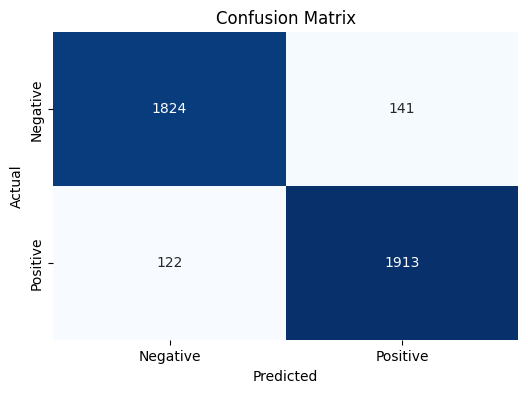

In [65]:
predict_sentiment_and_evaluate(model, tokenizer, X_test, y_test, device)